參考文件
1. Yoo, Jae-Chern, and Tae Hee Han. "Fast normalized cross-correlation." Circuits, systems and signal processing 28.6 (2009): 819-843.

In [99]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import itertools
import queue
from scipy.signal import convolve2d, correlate2d

In [100]:
img = cv2.imread('./source/Die1.tif')
template = cv2.imread('./template/Die-Template.tif')

In [101]:
img_gray = img[:, :, 2]*0.299 + img[:, :, 1]*0.587 + img[:, :, 0]*0.114
img_gray = img_gray.astype(np.uint8)

template_gray = template[:, :, 2]*0.299 + template[:, :, 1]*0.587 + template[:, :, 0]*0.114
template_gray = template_gray.astype(np.uint8)

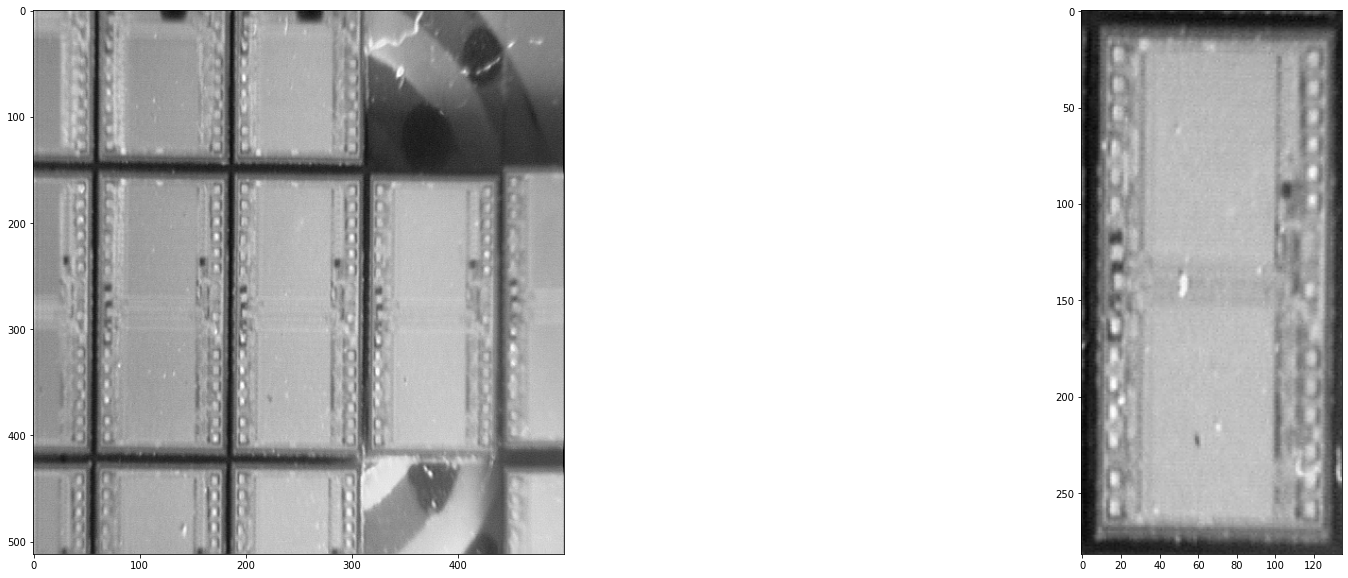

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax[0].imshow(img_gray, cmap='gray')
ax[1].imshow(template_gray, cmap='gray')

![](img/texureMatching公式.jpg)

In [103]:
template_gray = template_gray[::2, ::2]
img_gray = img_gray[::2, ::2]

In [104]:
h, w = template_gray.shape
template_norm = template_gray - np.mean(template_gray)

In [105]:
# pad
pad = np.array(template_gray.shape) // 2
padded_img_gray = np.ones([img_gray.shape[0] + pad[0]*2, img_gray.shape[1] + pad[1]*2]) * 0
padded_img_gray[pad[0]:-pad[0], pad[1]:-pad[1]] = img_gray

# conv windows
view_shape = tuple(np.subtract(padded_img_gray.shape, template_gray.shape) + 1) + template_gray.shape
strides = padded_img_gray.strides + padded_img_gray.strides
sub_matrices = np.lib.stride_tricks.as_strided(padded_img_gray, view_shape, strides)

In [106]:
R = np.zeros([*sub_matrices.shape[:2]])
for i, j in itertools.product(range(sub_matrices.shape[0]), range(sub_matrices.shape[1])):
    img_norm = sub_matrices[i, j] - np.mean(sub_matrices[i, j])
    
    R[i, j] = np.sum(template_norm * img_norm) / np.sqrt(np.sum(template_norm**2) * np.sum(img_norm**2))  

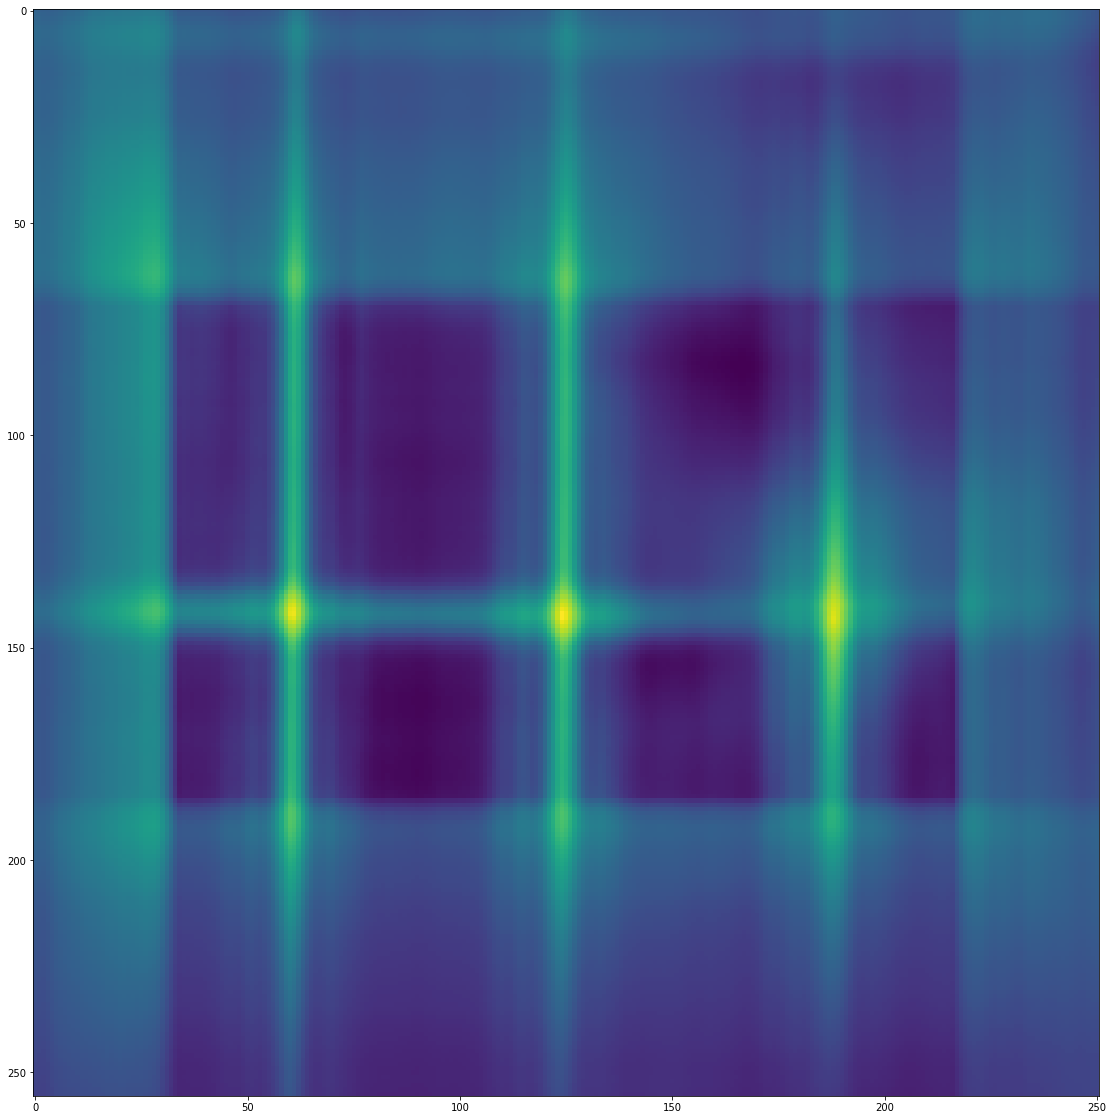

In [107]:
plt.figure(figsize=(20, 20))
plt.imshow(R)

In [173]:
m = np.einsum('ij,klij->kl', template_norm, sub_matrices)
n = np.einsum('klij->kl', sub_matrices) / (w*h) * np.sum(template_norm)

I_mean = np.einsum('klij->kl', sub_matrices) / (w*h)

b = np.sum(template_norm**2) * \
    (np.einsum('klij,klij->kl', sub_matrices, sub_matrices) - 2 * np.einsum('klij->kl', sub_matrices) * I_mean + (w*h)*I_mean**2)

b = np.sqrt(b)

r = (m - n) / b

0.7602851390838623


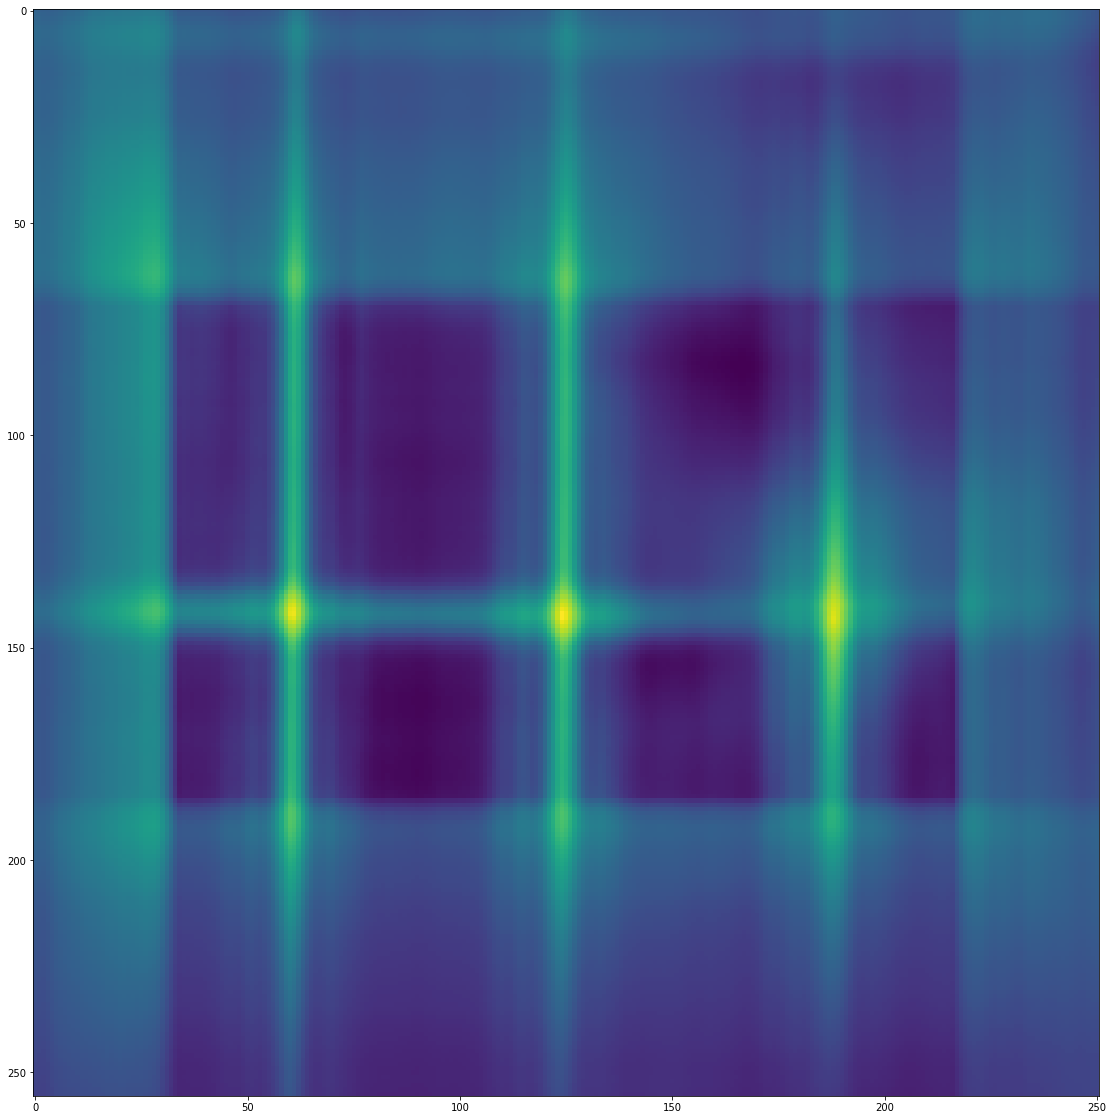

In [37]:
plt.figure(figsize=(20, 20))
plt.imshow(r)

In [38]:
img_gray.shape

(256, 250)

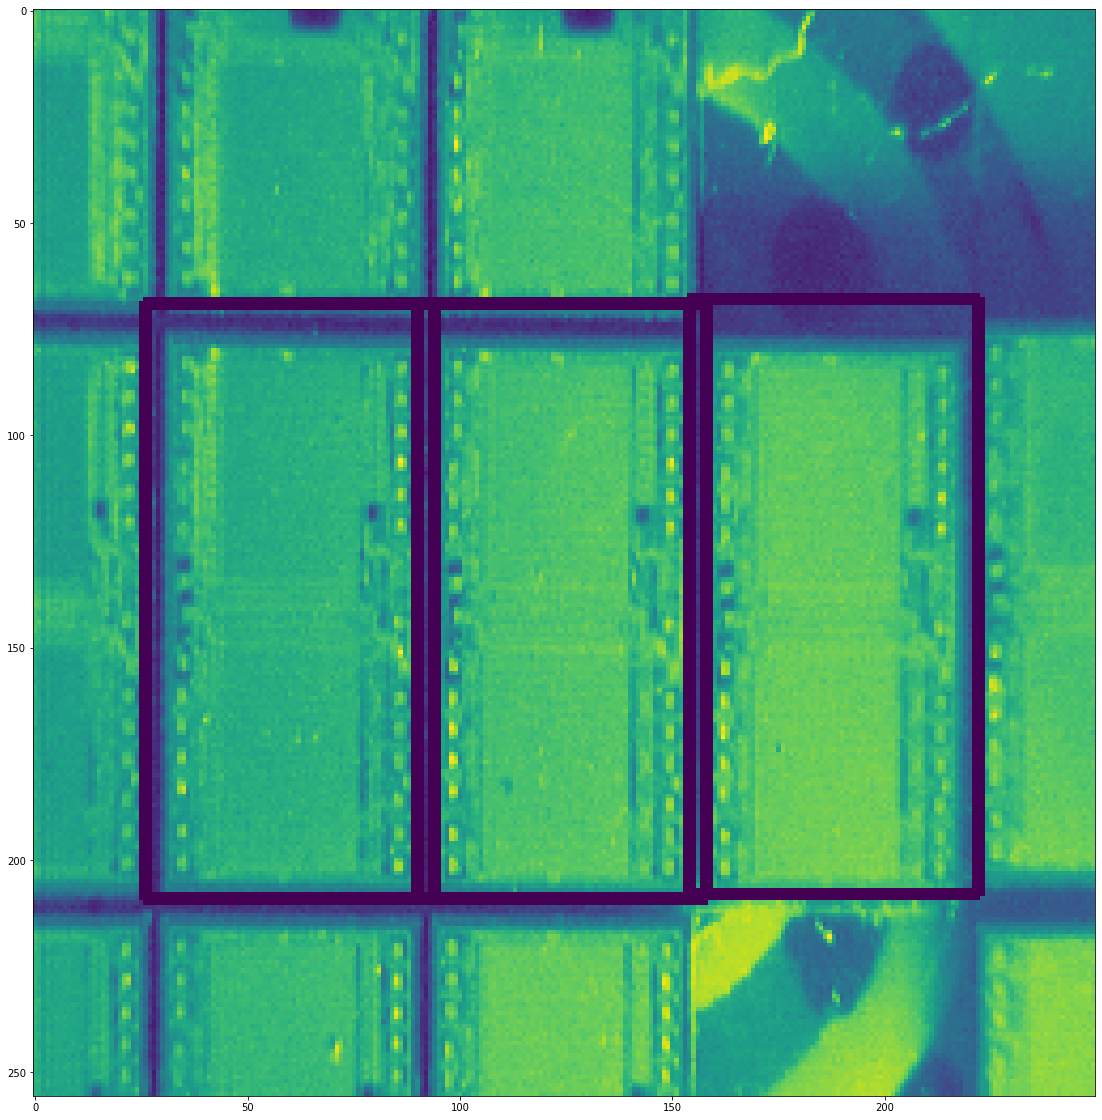

In [39]:
w, h = template_gray.shape[::-1]
img_res = img_gray.copy()

threshold = 0.8
loc = np.where( r >= threshold)

targetPoint = []
for n, (x, y) in enumerate(zip(*loc)):
    if n == 0:
        targetPoint.append([x, y])
    else:
        dis = sorted([np.sqrt((x-i)**2 + (y-j)**2) for i, j in targetPoint])            
        if dis[0] > img_gray.shape[1]*0.05:
            targetPoint.append([x, y])            
            

for pt in targetPoint:
    cv2.rectangle(img_res, (pt[1] - w//2, pt[0] - h//2), (pt[1] + w//2, pt[0] + h//2), (0, 0, 255), 2)

plt.figure(figsize=(20, 20))
plt.imshow(img_res)

In [40]:
targetPoint

[[138, 188], [139, 60], [139, 124]]

In [20]:
sample_imgs = [img_gray]
sample_templates = [template_gray]

for _ in range(3):
    sample_imgs.append(sample_imgs[-1][::2, ::2])
    sample_templates.append(sample_templates[-1][::2, ::2])

In [48]:
init_level = len(sample_imgs) - 1

que = queue.Queue()

# [init_level], [start_point], [w], [h]
que.put([init_level, np.array([0, 0]), sample_imgs[-1].shape[1], sample_imgs[-1].shape[0]])

result_point = []

In [49]:
while True:
    if que.empty():
        break
    
    
    now_level, start_point, subimage_w, subImage_h = que.get()
    print(now_level, start_point, subimage_w, subImage_h)

    now_template = sample_templates[now_level]
    now_img = sample_imgs[now_level][start_point[0]:start_point[0] + subImage_h, start_point[1]:start_point[1] + subimage_w]


    # pad
    pad = np.array(now_template.shape) // 2
    padded_img_gray = np.ones([now_img.shape[0] + pad[0]*2, now_img.shape[1] + pad[1]*2]) * 0
    padded_img_gray[pad[0]:-pad[0], pad[1]:-pad[1]] = now_img


    # change view for conv
    view_shape = tuple(np.subtract(padded_img_gray.shape, now_template.shape) + 1) + now_template.shape
    strides = padded_img_gray.strides + padded_img_gray.strides
    sub_matrices = np.lib.stride_tricks.as_strided(padded_img_gray, view_shape, strides)


    #
    template_h, template_w = now_template.shape
    T_norm = now_template - np.mean(now_template)  
    I_norm_mean = np.einsum('klij->kl', sub_matrices) / (template_w*template_h)

    #
    m = np.einsum('ij,klij->kl', T_norm, sub_matrices)
    n = I_norm_mean * np.sum(T_norm)

    
    T_norm_sum = np.sum(T_norm**2)
    
    I_norm_sum = np.einsum('klij,klij->kl', sub_matrices, sub_matrices) \
                    - 2 * np.einsum('klij->kl', sub_matrices) * I_norm_mean \
                    + (template_w*template_h) * I_norm_mean**2

    R = (m - n) / np.sqrt(T_norm_sum * I_norm_sum)

    # 
    threshold = 0.7
    loc = np.where( R >= threshold)

    #
    targetPoint = []
    for n, (x, y) in enumerate(zip(*loc)):
        if n == 0:
            targetPoint.append([x, y])
        else:
            dis = sorted([np.sqrt((x-i)**2 + (y-j)**2) for i, j in targetPoint])            
            if dis[0] > now_img.shape[1]*0.1:
                targetPoint.append([x, y])            
                break
    if len(targetPoint) <= 0:
        print('no target')
        continue

    targetPoint = np.array(targetPoint) + start_point
    
    #
    if now_level == 1:
        print('output', targetPoint*2)
        result_point.extend(targetPoint*2)
    else:
        for x, y in targetPoint:
            h_upper = x - int(now_template.shape[0]*0.5) if x - now_template.shape[0]*0.5 > 0 else 0
            w_upper = y - int(now_template.shape[1]*0.5) if y - now_template.shape[1]*0.5 > 0 else 0

            que.put([now_level-1, np.array([h_upper, w_upper])*2, int(now_template.shape[1]*2), int(now_template.shape[0]*2)])

3 [0 0] 32 32
2 [18  8] 18 36
2 [18 24] 18 36
1 [32 12] 34 72
output [[138  60]
 [140  52]]
1 [36 10] 34 72
output [[138  58]]
1 [32 44] 34 72
output [[126 124]
 [136 124]]
1 [36 42] 34 72
output [[136 124]
 [144 122]]


In [43]:
result_point

[array([138,  60], dtype=int64),
 array([140,  52], dtype=int64),
 array([138,  58], dtype=int64),
 array([126, 124], dtype=int64),
 array([136, 124], dtype=int64),
 array([136, 124], dtype=int64),
 array([144, 122], dtype=int64)]

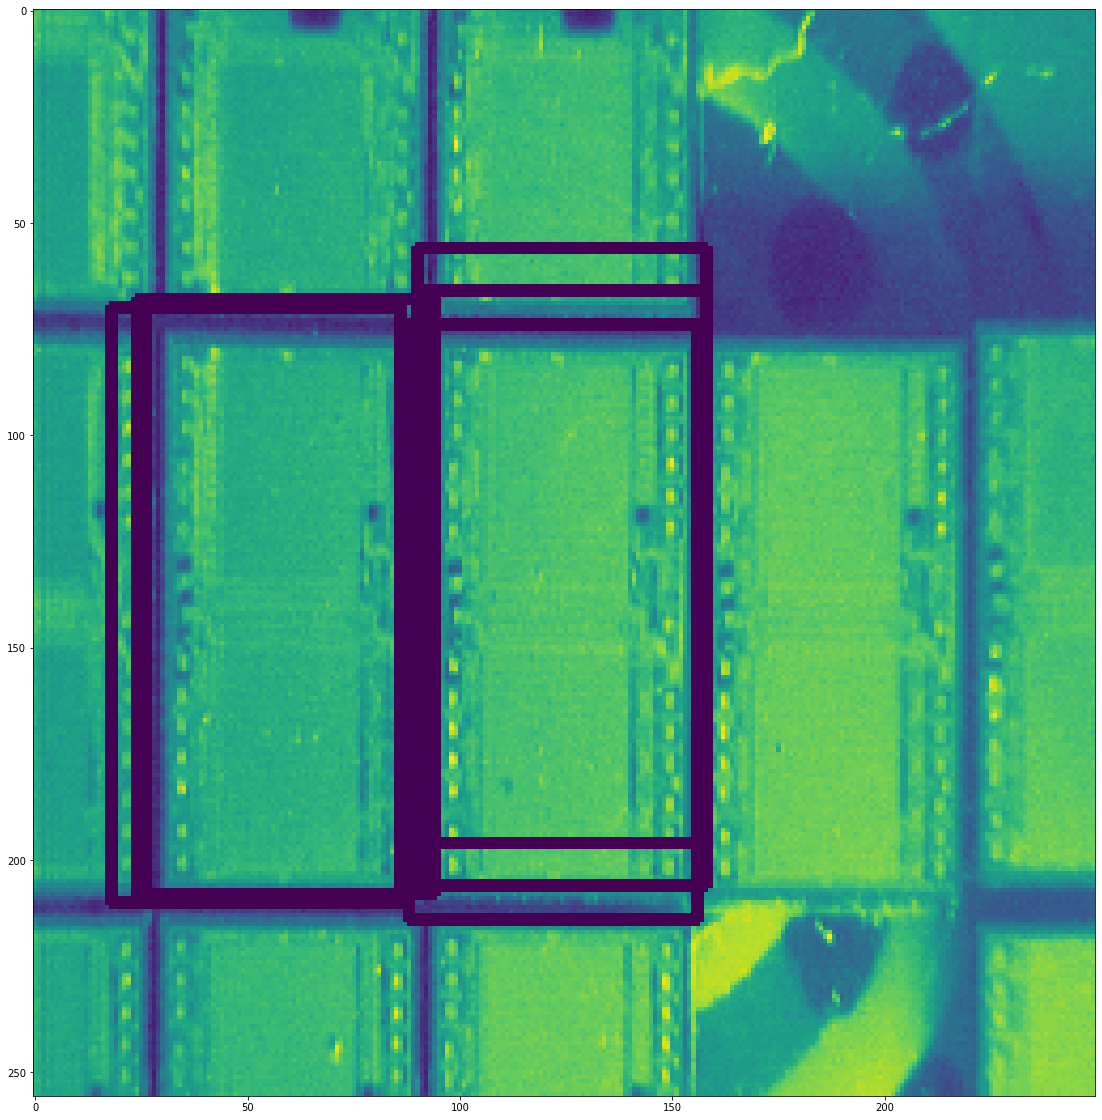

In [44]:
img_res = img_gray.copy()
w, h = template_gray.shape[::-1]

for pt in result_point:
    cv2.rectangle(img_res, (pt[1] - w//2, pt[0] - h//2), (pt[1] + w//2, pt[0] + h//2), (0, 0, 255), 2)

plt.figure(figsize=(20, 20))
plt.imshow(img_res)

# with OpenCV

In [93]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import itertools
from scipy.signal import convolve2d, correlate2d

In [94]:
img = cv2.imread('./source/Die1.tif')
template = cv2.imread('./template/Die-Template.tif')

In [95]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

In [96]:
res = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)

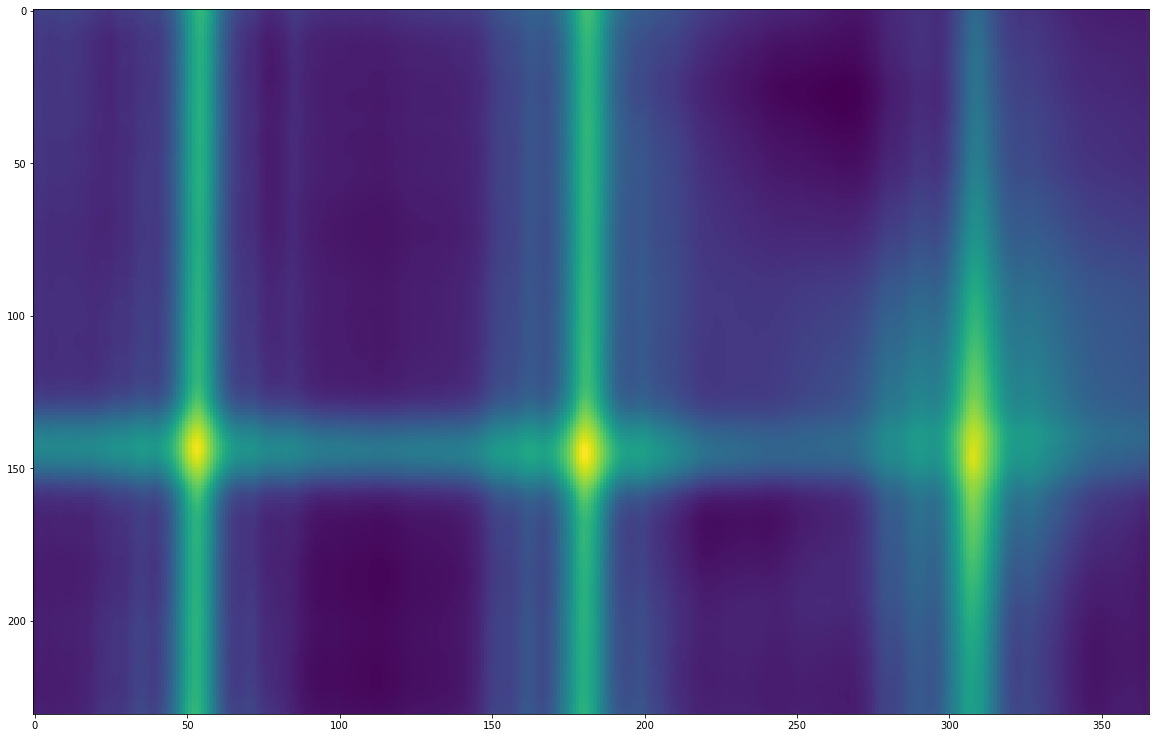

In [97]:
plt.figure(figsize=(20, 20))
plt.imshow(res)

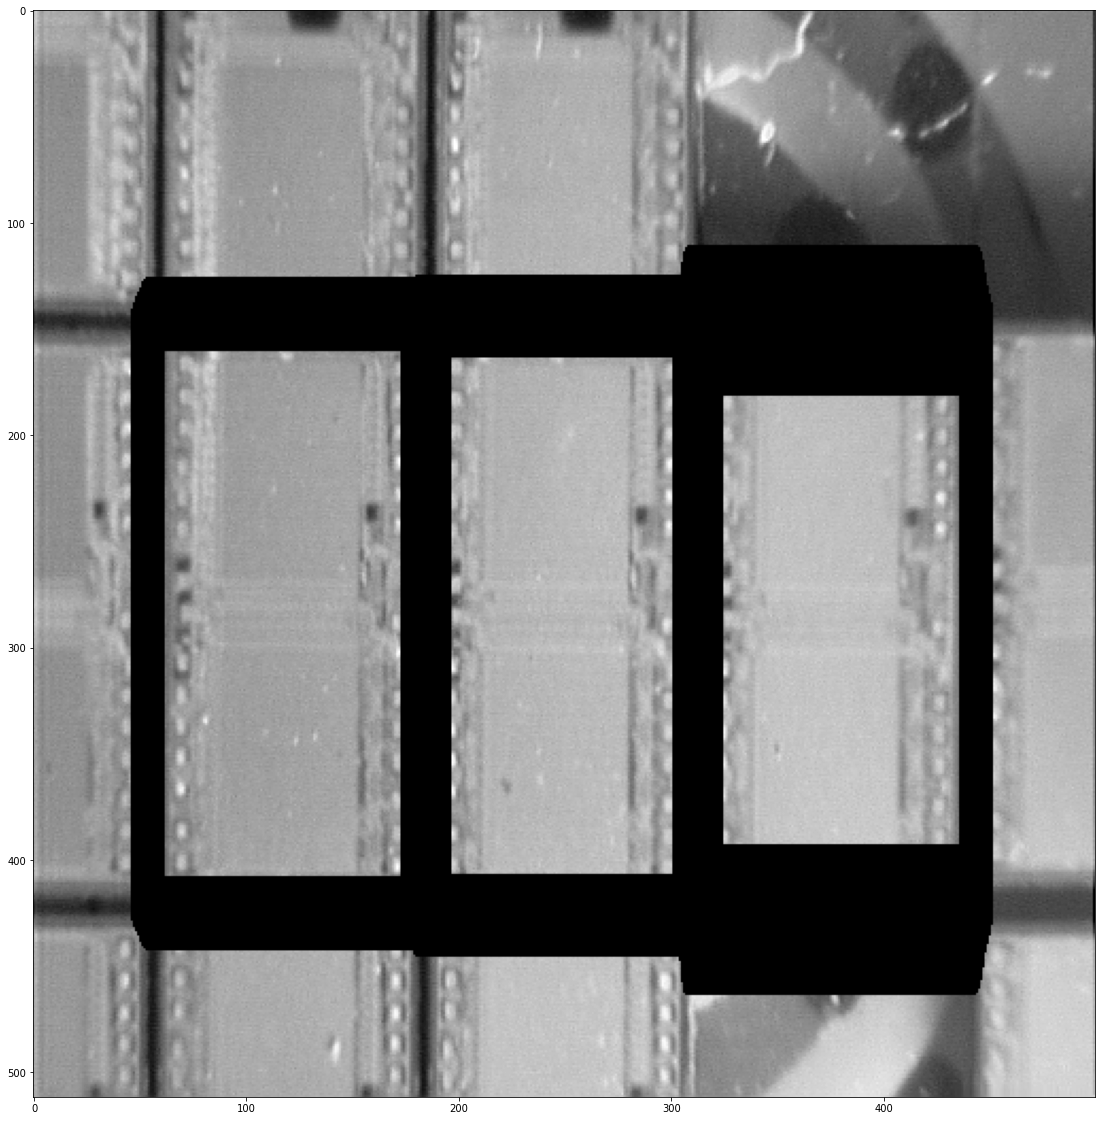

In [98]:
w, h = template_gray.shape[::-1]
img_res = img_gray.copy()

threshold = 0.6
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_res, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

plt.figure(figsize=(20, 20))
plt.imshow(img_res, cmap='gray')